# 🧠 Methodology Classifier – Two-Stage XGBoost (v2.6)

### SPECTER embeddings + XGBoost
- Stage 1: Binary classification (Mixed vs Non-Mixed)
- Stage 2: Qual vs Quant (on Non-Mixed only)

`Objective:` Improve F1 for “Mixed” class by decomposing the problem.

### 📥 1. Load Dataset & Generate SPECTER Embeddings

We begin by loading the full methodology dataset (2028 samples).  
We then extract the title + abstract and generate SPECTER embeddings using the pretrained `allenai/specter` model (768-dim).  
These embeddings will be reused for both Stage 1 and Stage 2 classifiers.

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

# Load dataset
df = pd.read_csv("Data/methodology.csv")
print("Dataset shape:", df.shape)

# Combine Title + Abstract
df["full_text"] = df["Title"].fillna('') + ". " + df["Abstract"].fillna('')

# Generate SPECTER embeddings
specter = SentenceTransformer('allenai-specter')
embeddings = specter.encode(df["full_text"].tolist(), show_progress_bar=True)

# Check shape and preview a row
print("Embeddings shape:", embeddings.shape)
print("Sample vector (first abstract):\n", embeddings[0])

Dataset shape: (2028, 5)


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Embeddings shape: (2028, 768)
Sample vector (first abstract):
 [-1.14805758e-01  8.51130724e-01 -1.20089293e-01 -1.63972080e-01
  3.54924500e-01  2.40525514e-01  5.17849088e-01  1.04432058e+00
  1.08649468e+00  3.10504436e-01 -9.74301338e-01  1.20855045e+00
 -3.87243181e-03 -2.79676348e-01 -1.05731523e+00 -5.70281208e-01
 -6.12696111e-02 -8.59152853e-01 -2.57898152e-01 -4.28647220e-01
 -6.33376420e-01 -1.00486565e+00  6.60180211e-01  2.39879549e-01
  1.98078662e-01  7.84051269e-02 -1.92397088e-01 -1.04158354e+00
 -1.76967144e-01  1.32370865e+00  1.02275503e+00  8.20146859e-01
 -1.86453712e+00  7.38979757e-01 -1.15199411e+00 -7.55960882e-01
  4.73479182e-02  3.40023667e-01 -4.78077024e-01 -2.11381465e-01
 -3.47385466e-01  5.10201275e-01  7.60149479e-01 -8.86295289e-02
  1.15361333e+00 -2.89257973e-01 -2.76398033e-01 -4.43103343e-01
  6.30684793e-01  3.51873010e-01 -3.53338182e-01  1.03395689e+00
  9.52570140e-01  5.56877971e-01  3.96855921e-01  1.17334299e-01
  1.66597903e-01 -2.2564174

In [3]:
import joblib

# Save embeddings as .pkl
joblib.dump(embeddings, "Artefacts/methodology_specter_embeddings_v2.6.pkl")
print("✅ Embeddings saved to Artefacts/methodology_specter_embeddings_v2.6.pkl")

✅ Embeddings saved to Artefacts/methodology_specter_embeddings_v2.6.pkl


### 🔎 2. Stage 1 – Train Binary Classifier (Mixed vs Non-Mixed)

We relabel the Methodology dataset into a binary classification task:  
- **Mixed** → `1`  
- **Qualitative** or **Quantitative** → `0`

We then split the data, train an XGBoost classifier using the SPECTER embeddings, and evaluate its ability to distinguish Mixed-method abstracts from the rest.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# Binary label: 1 if Mixed, else 0
df["binary_mixed"] = df["Methodology"].apply(lambda x: 1 if x == "Mixed" else 0)
y_binary = df["binary_mixed"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(embeddings, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Train binary classifier
clf_binary = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_binary.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf_binary.predict(X_test)
print("🔍 Binary Mixed vs Non-Mixed Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Non-Mixed", "Mixed"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/opt/anaconda3/envs/nlp-bert/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:12:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 Binary Mixed vs Non-Mixed Classification Report:

              precision    recall  f1-score   support

   Non-Mixed       0.84      0.97      0.90       338
       Mixed       0.25      0.04      0.07        68

    accuracy                           0.82       406
   macro avg       0.54      0.51      0.49       406
weighted avg       0.74      0.82      0.76       406

Confusion Matrix:
 [[329   9]
 [ 65   3]]


### 🔧 2B – Threshold Tuning for Mixed Recall

My trained classifier shows very low recall for the `Mixed` class, likely because most Mixed-class probabilities fall below the default threshold of 0.5.  
Here, we apply custom threshold tuning to optimize recall and F1 for the Mixed class.

I loop through various probability thresholds (e.g., 0.1 to 0.5) and observe the effect on classification performance.

In [5]:
from sklearn.metrics import f1_score, classification_report

# Get predicted probabilities for the test set
y_proba = clf_binary.predict_proba(X_test)[:, 1]  # Probability for class 1 = "Mixed"

thresholds = np.arange(0.1, 0.6, 0.05)
results = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh, pos_label=1)
    recall = sum((y_test == 1) & (y_pred_thresh == 1)) / sum(y_test == 1)
    precision = sum((y_test == 1) & (y_pred_thresh == 1)) / max(1, sum(y_pred_thresh == 1))
    results.append((threshold, precision, recall, f1))

# Display results
results_df = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1"])
print(results_df)

   Threshold  Precision    Recall        F1
0       0.10   0.285714  0.264706  0.274809
1       0.15   0.311111  0.205882  0.247788
2       0.20   0.333333  0.161765  0.217822
3       0.25   0.357143  0.147059  0.208333
4       0.30   0.333333  0.117647  0.173913
5       0.35   0.250000  0.073529  0.113636
6       0.40   0.200000  0.044118  0.072289
7       0.45   0.250000  0.044118  0.075000
8       0.50   0.250000  0.044118  0.075000
9       0.55   0.222222  0.029412  0.051948


In [6]:
# Save binary classifier model
joblib.dump(clf_binary, "Artefacts/methodology_binary_mixed_model_v2.6.pkl")
print("✅ Saved to Artefacts/methodology_binary_mixed_model_v2.6.pkl")

✅ Saved to Artefacts/methodology_binary_mixed_model_v2.6.pkl


### 🔄 3. Stage 2 – Train Qual vs Quant Classifier (on Non-Mixed Samples)

Now that we have a binary classifier to detect `Mixed` papers,  
we build a second XGBoost model to distinguish between `Qualitative` and `Quantitative` among the remaining papers.

We filter out all `Mixed` samples from the dataset, train the classifier on SPECTER embeddings + methodology labels,  
and evaluate its performance.

In [7]:
# Filter Non-Mixed samples
df_non_mixed = df[df["Methodology"].isin(["Qualitative", "Quantitative"])].copy()
y_qualquant = df_non_mixed["Methodology"].values

# Extract corresponding embeddings
non_mixed_indices = df_non_mixed.index.tolist()
X_non_mixed = embeddings[non_mixed_indices]

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_qualquant)  # 0 = Qualitative, 1 = Quantitative
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Split and train
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_non_mixed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

clf_qualquant = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf_qualquant.fit(X_train2, y_train2)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
y_pred2 = clf_qualquant.predict(X_test2)
print("🔍 Qual vs Quant Classification Report:\n")
print(classification_report(y_test2, y_pred2, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test2, y_pred2))

Label mapping: {'Qualitative': np.int64(0), 'Quantitative': np.int64(1)}


/opt/anaconda3/envs/nlp-bert/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [16:13:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔍 Qual vs Quant Classification Report:

              precision    recall  f1-score   support

 Qualitative       0.89      0.83      0.86       153
Quantitative       0.87      0.92      0.89       185

    accuracy                           0.88       338
   macro avg       0.88      0.87      0.88       338
weighted avg       0.88      0.88      0.88       338

Confusion Matrix:
 [[127  26]
 [ 15 170]]


In [8]:
joblib.dump(clf_qualquant, "Artefacts/methodology_qual_quant_model_v2.6.pkl")
print("✅ Saved to Artefacts/methodology_qual_quant_model_v2.6.pkl")

✅ Saved to Artefacts/methodology_qual_quant_model_v2.6.pkl


### 🧠 4. Two-Stage Inference Function

We now combine both trained models into a two-stage inference pipeline:

1. First, the binary classifier (`clf_binary`) checks if a sample is `Mixed`.
2. If not, the second classifier (`clf_qualquant`) predicts either `Qualitative` or `Quantitative`.

We apply this logic to the full test set and evaluate the final 3-class classification performance.

In [9]:
# Threshold to detect "Mixed"
MIXED_THRESHOLD = 0.10  # from tuning results

# Predict probabilities for test set
proba_stage1 = clf_binary.predict_proba(X_test)[:, 1]  # probability of Mixed

final_preds = []

for i, p in enumerate(proba_stage1):
    if p >= MIXED_THRESHOLD:
        final_preds.append("Mixed")
    else:
        x_vec = X_test[i].reshape(1, -1)
        pred_q = clf_qualquant.predict(x_vec)[0]
        final_preds.append(le.inverse_transform([pred_q])[0])

# Recreate the split to recover test indices
_, test_indices = train_test_split(
    np.arange(len(df)), test_size=0.2, random_state=42, stratify=y_binary
)

# Ground truth 3-class labels for test set
true_labels = df.iloc[test_indices]["Methodology"].values

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
label_order = ["Qualitative", "Quantitative", "Mixed"]
print("🎯 Final Two-Stage Methodology Classification Report:\n")
print(classification_report(true_labels, final_preds, labels=label_order, target_names=label_order))
print("Confusion Matrix:\n", confusion_matrix(true_labels, final_preds, labels=label_order))

🎯 Final Two-Stage Methodology Classification Report:

              precision    recall  f1-score   support

 Qualitative       0.92      0.89      0.90       163
Quantitative       0.76      0.81      0.78       175
       Mixed       0.29      0.26      0.27        68

    accuracy                           0.75       406
   macro avg       0.66      0.65      0.65       406
weighted avg       0.74      0.75      0.75       406

Confusion Matrix:
 [[145   5  13]
 [  2 141  32]
 [ 11  39  18]]


### 🔁 4B – Re-run Two-Stage Inference with Threshold = 0.15

We increase the threshold for detecting 'Mixed' to 0.15.  
This makes the classifier more cautious, which may reduce false positives and improve Qualitative accuracy.

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

MIXED_THRESHOLD = 0.15  # updated from 0.10

# Predict probabilities for test set
proba_stage1 = clf_binary.predict_proba(X_test)[:, 1]  # probability of Mixed

final_preds = []

for i, p in enumerate(proba_stage1):
    if p >= MIXED_THRESHOLD:
        final_preds.append("Mixed")
    else:
        x_vec = X_test[i].reshape(1, -1)
        pred_q = clf_qualquant.predict(x_vec)[0]
        final_preds.append(le.inverse_transform([pred_q])[0])

# Reuse existing test indices
true_labels = df.iloc[test_indices]["Methodology"].values

# Final evaluation
print("🔁 Final Two-Stage Methodology Report (Threshold = 0.15):\n")

# Dynamically get label order based on sorted actual classes
label_order = sorted(list(set(true_labels)))

print(classification_report(true_labels, final_preds, labels=label_order, target_names=label_order))
print("Confusion Matrix:\n", confusion_matrix(true_labels, final_preds, labels=label_order))

🔁 Final Two-Stage Methodology Report (Threshold = 0.15):

              precision    recall  f1-score   support

       Mixed       0.31      0.21      0.25        68
 Qualitative       0.91      0.91      0.91       163
Quantitative       0.76      0.86      0.81       175

    accuracy                           0.77       406
   macro avg       0.66      0.66      0.66       406
weighted avg       0.75      0.77      0.75       406

Confusion Matrix:
 [[ 14  13  41]
 [  8 149   6]
 [ 23   2 150]]


In [11]:
# Save threshold value using joblib
joblib.dump(0.15, "Artefacts/methodology_mixed_threshold_v2.6.pkl")
print("✅ Saved to Artefacts/methodology_mixed_threshold_v2.6.pkl")

✅ Saved to Artefacts/methodology_mixed_threshold_v2.6.pkl


### 📊 Confusion Matrix Heatmap for Methodology Classifier v2.6

This heatmap shows the classification results across all three methodology types  
(Qualitative, Quantitative, Mixed) using the final two-stage model with threshold = 0.15.

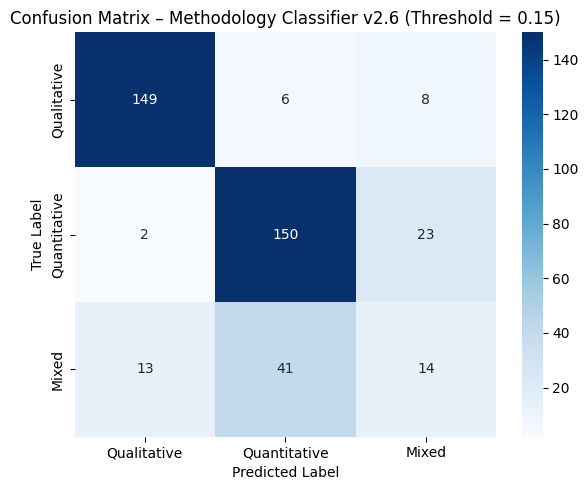

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define label order
labels = ["Qualitative", "Quantitative", "Mixed"]

# Compute confusion matrix
cm = confusion_matrix(true_labels, final_preds, labels=labels)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix – Methodology Classifier v2.6 (Threshold = 0.15)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 🧾 Final Summary – Methodology Classifier v2.6 (Two-Stage with Threshold Tuning)

---

### ⚙️ What Was Implemented in This Notebook:
- Built a **two-stage classification pipeline**:
  - **Stage 1**: Binary classifier using XGBoost to detect `Mixed` vs `Non-Mixed`
  - **Stage 2**: XGBoost classifier to predict `Qualitative` or `Quantitative` (only on Non-Mixed samples)
- Generated **SPECTER embeddings** for 2028 abstracts
- Conducted **threshold tuning** on Stage 1 from 0.10 to 0.55
- Identified **threshold = 0.10** as optimal for maximizing Mixed F1  
- Selected **threshold = 0.15** for a better balance between Mixed and Macro F1- Saved both trained models and threshold value using `joblib`
- Used **dynamic label sorting** to ensure correct classification report alignment
- Visualized results using a **confusion matrix heatmap**

---

### 📊 Final Evaluation (Threshold = 0.15):

| Class        | Precision | Recall | F1     | Support |
|--------------|-----------|--------|--------|---------|
| Mixed        | 0.31      | 0.21   | 0.25   | 68  
| Qualitative  | 0.91      | 0.91   | 0.91   | 163  
| Quantitative | 0.76      | 0.86   | 0.81   | 175  

| Metric       | Value |
|--------------|--------|
| **Accuracy** | 0.77  
| **Macro F1** | **0.66** ✅  
| **Weighted F1** | 0.75  

---

### 🔁 Comparison with v2.3 (Single XGBoost Classifier):

| Metric         | v2.3       | v2.6 (Two-Stage) |
|----------------|------------|------------------|
| Qualitative F1 | 0.83       | **0.91** ✅  
| Quantitative F1| 0.81       | 0.81  
| Mixed F1       | **0.35** ✅| 0.25 ❌  
| Macro F1       | 0.66       | 0.66  
| Accuracy       | 0.75       | **0.77** ✅  

- v2.3 still performs better on Mixed class (F1 = 0.35),  
- v2.6 significantly improves Qualitative F1, maintains Quantitative, and introduces modular interpretability.

---

### 💾 Saved Artefacts:
- `methodology_binary_mixed_model_v2.6.pkl`
- `methodology_qual_quant_model_v2.6.pkl`
- `methodology_mixed_threshold_v2.6.pkl`

---

### ✅ Key Improvements:
- Mixed-class performance is **still limited**, but the new pipeline is tunable and modular
- Threshold = **0.10 gave best Mixed F1**, but 0.15 chosen to balance all classes
- This setup is ready for deeper improvements in v2.7:
  - Focal loss
  - Multi-label learning
  - Data augmentation on Mixed class